In [1]:
import Pkg; 
Pkg.activate(".."); Pkg.instantiate();
using RxInfer, Random, Plots, StableRNGs, Distributions

  Activating project at `/ws`
┌ Warning: The active manifest file is an older format with no julia version entry. Dependencies may have been resolved with a different julia version.
└ @ nothing /ws/Manifest.toml:0


In [2]:
rng   = StableRNG(1234)

datastream   = Subject(Float64)
observations = labeled(Val((:y, )), combineLatest(datastream))

position, noise = 1, 0.1

function generate_data(rng, x, v)
  noise = rand(rng, Normal(0, v))
  y = x + noise
  return y
end

generate_data (generic function with 1 method)

In [3]:
# Testing the datastream
test_subscribtion = subscribe!(observations, (data) -> println(data))

for i in 1:5
  data = generate_data(rng, position, noise)
  next!(datastream, data)
end

unsubscribe!(test_subscribtion)

(y = 1.051949454850376,)
(y = 1.0905139726861126,)
(y = 0.8324338842090443,)
(y = 0.8705266555587259,)
(y = 0.9315634529141368,)


In [4]:
# Defining the model
@model function model(y, _t, _m1_u, _m1_v, _w1_s, _w1_r, _m2_u, _m2_v, _w2_s, _w2_r)
  sw ~ Categorical(_t)

  m[1] ~ Normal(mean = _m1_u, variance = _m1_v)
  w[1] ~ Gamma(shape = _w1_s, rate = _w1_r)

  m[2] ~ Normal(mean = _m2_u, variance = _m2_v)
  w[2] ~ Gamma(shape = _w2_s, rate = _w2_r)

  y ~ NormalMixture(switch=sw, m=m, p=w)
end

model_autoupdates = @autoupdates begin
  _t = params(q(sw))
  _m1_u, _m1_v = params(q(m[1]))
  _w1_s, _w1_r = params(q(w[1]))
  _m2_u, _m2_v = params(q(m[2]))
  _w2_s, _w2_r = params(q(w[2]))
end

@autoupdates begin
    _t = params(q(sw))
    (_m1_u, _m1_v) = params(q(m[1]))
    (_w1_s, _w1_r) = params(q(w[1]))
    (_m2_u, _m2_v) = params(q(m[2]))
    (_w2_s, _w2_r) = params(q(w[2]))
end


In [5]:
imarginals = @initialization begin
  q(sw) = Categorical([0.5, 0.5])
  q(m) = [NormalMeanVariance(-2.0, 1e3), NormalMeanVariance(2.0, 1e3)]
  q(w) = [vague(GammaShapeRate), vague(GammaShapeRate)]
  #q(m) = [Normal(0, 1), Normal(1, 1)]
  #q(w) = [Gamma(1, 1), Gamma(1, 1)]
end

ireturnvars = (
  sw = KeepLast(),
  m = KeepLast(),
  w = KeepLast(),
)

engine = infer(
  model           = model(),
  constraints     = MeanField(),
  datastream      = observations,
  autoupdates     = model_autoupdates,
  initialization  = imarginals,
  #iterations      = 10,
  keephistory     = 100,
  historyvars     = ireturnvars,
  autostart       = false,
  free_energy     = true,
  #addons          = AddonLogScale(),
  postprocess     = UnpackMarginalPostprocess(),
)

RxInferenceEngine:
  Posteriors stream    | enabled for (m, w, sw)
  Free Energy stream   | enabled
  Posteriors history   | available for (m, w, sw)
  Free Energy history  | available
  Enabled events       | [  ]

In [6]:
# Start the engine
RxInfer.start(engine)

# Generate some data
for i in 1:100
  data = generate_data(rng, position, noise)
  next!(datastream, data)
end



In [7]:
RxInfer.stop(engine)

NormalWeightedMeanPrecision{Float64}(xi=4.6569247226005743e11, w=5.00000000000001e11)


┌ Info: Saved animation to /ws/notebooks/normal_mixture.gif
└ @ Plots /root/.julia/packages/Plots/Ec1L1/src/animation.jl:156


Plots.AnimatedGif("/ws/notebooks/normal_mixture.gif")
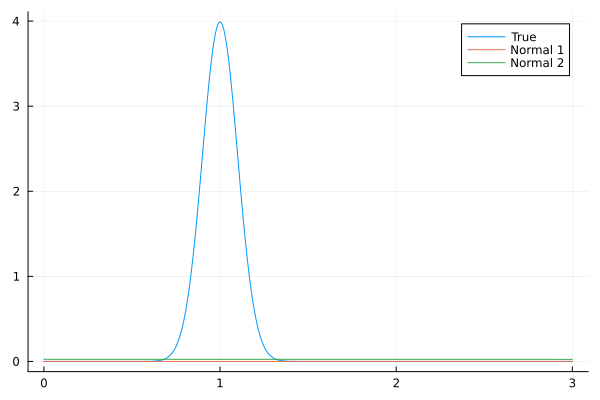

In [15]:
println(engine.history[:m][1][1])
# Plot the results
anim = @animate for i in 1:100
  r = range(0, 3, length=1000)
  p = plot(r, (x) -> pdf.(Normal(position, noise), x), label="True")

  p = plot!(r, (x) -> pdf.(engine.history[:m][3][1], x), label="Normal 1")
  p = plot!(r, (x) -> pdf.(engine.history[:m][3][2], x), label="Normal 2")
end

gif(anim, "normal_mixture.gif", fps = 5)